In [2]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil

# pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from torchinfo import summary

# Dermatological Conditions Classification
### Run a classification CNN model on different types of dermatological conditions 

In [3]:
os.makedirs('data')
# import shutil
# shutil.rmtree('/kaggle/working/split_data')

## Copy Selected Data to a New Data Folder:

In [4]:
data_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/"
dest_path = '/kaggle/working/data/'
data_all = os.listdir(data_path)
print(data_all)


skin_targets = ["3. Atopic Dermatitis - 1.25k", 
                "7. Psoriasis pictures Lichen Planus and related diseases - 2k",
                "1. Eczema 1677"#, 
                # "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k"
               ] 
#0. Warts Molluscum and other Viral Infections - 2103
#9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k

for target in skin_targets:
    target_path = data_path + target
    target_dest_path = dest_path + target
    print(f"\nTarget Name: {target}")
    print(f"Train Len: {len(os.listdir(target_path))}")
    shutil.copytree(target_path, target_dest_path)

['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '4. Basal Cell Carcinoma (BCC) 3323', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '5. Melanocytic Nevi (NV) - 7970', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k', '3. Atopic Dermatitis - 1.25k', '6. Benign Keratosis-like Lesions (BKL) 2624', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '2. Melanoma 15.75k']

Target Name: 3. Atopic Dermatitis - 1.25k
Train Len: 1257

Target Name: 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Train Len: 2055

Target Name: 1. Eczema 1677
Train Len: 1677


In [5]:
!pip install split_folders
import splitfolders

## Change Targets' Names:

In [6]:
path = "/kaggle/working/data/"

dir_list = os.listdir(path) 
print(f"num classes: {len(dir_list)}")

os.rename(path + "1. Eczema 1677", path + "Eczema")
os.rename(path + "7. Psoriasis pictures Lichen Planus and related diseases - 2k", path + "Psoriasis + Lichen Planus")
os.rename(path + "3. Atopic Dermatitis - 1.25k", path + "Atopic Dermatitis")
# # os.rename(path + "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k", path + "Fungal Infections")

skin_targets_renamed = os.listdir(path)
skin_targets_renamed

num classes: 3


['Psoriasis + Lichen Planus', 'Eczema', 'Atopic Dermatitis']

## Split Data to Train, Test and Validation Folders

In [7]:
os.makedirs('split_data')
os.makedirs('split_data/train')
os.makedirs('split_data/val')
os.makedirs('split_data/test')

loc = "/kaggle/working/data/"

splitfolders.ratio(loc, output ="split_data", ratio = (0.80,.1,.1))
# splitfolders.ratio(loc, output ="split_data", ratio = (0.70,.15,.15))

Copying files: 4989 files [00:00, 5232.10 files/s]


In [8]:
path = "/kaggle/working/split_data/train/Atopic Dermatitis"
dir_list = os.listdir(path) 
print(len(dir_list))
path = "/kaggle/working/split_data/val/Atopic Dermatitis"
dir_list = os.listdir(path) 
print(len(dir_list))

1005
125


## Create pytorch dataset

In [10]:
train_path = "/kaggle/working/split_data/train/"
val_path = "/kaggle/working/split_data/val/"
test_path = "/kaggle/working/split_data/test/"

# implement pytorch dataset:
class SkinDataset(Dataset):

    def __init__(self, mode = 'train', transform = transforms.ToTensor()):
        self.mode = mode 
        self.target_dict = {}
        self.skin_targets = skin_targets_renamed
        img_paths, img_targets = self.get_data()
        self.img_paths = img_paths
        self.img_targets = img_targets
        self.transform = transform
        
    def __len__(self): # == len(dataset)
        return len(self.img_paths)
        
    def __getitem__(self, index): # == dataset[index] 
        img = Image.open(self.img_paths[index])
        # img = img.filter(ImageFilter.GaussianBlur(radius=2)) #reduce noises
        img = self.transform(img)
        return {"img": img, "target": self.img_targets[index]}

    def get_data(self):
        dir_path = train_path if self.mode == 'train' else val_path if self.mode == 'val' else test_path
        image_paths = []
        image_target = []
        for i in range(len(skin_targets)):
            target_path = dir_path + self.skin_targets[i]
            self.target_dict[i] = self.skin_targets[i]
            print(f"target_path: {target_path}")
            for path in os.listdir(target_path):
                img_path = target_path + "/" + path
                image_paths.append(img_path)
                image_target.append(i) # target index
        return image_paths, image_target


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Flip images randomly
    # transforms.RandomRotation(degrees=10),    # Rotate more (10 → 20 degrees)
    # transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # More aggressive cropping
    transforms.RandomAffine(degrees=0, shear=20),  # Increase shear for perspective shifts
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Stronger distortions
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Apply perspective transformation
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Blur to prevent memorization
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Standard normalization
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Cutout to hide parts of the image
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentation for validation
    transforms.ToTensor()#,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train = SkinDataset(mode = 'train', transform = train_transform)
print(f"train len: {len(train)}") 

test = SkinDataset(mode = 'val', transform = val_transform)
print(f"test len: {len(test)}") 

val = SkinDataset(mode = 'test', transform = val_transform)
print(f"test len: {len(test)}") 

target_path: /kaggle/working/split_data/train/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/train/Eczema
target_path: /kaggle/working/split_data/train/Atopic Dermatitis
train len: 3990
target_path: /kaggle/working/split_data/val/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/val/Eczema
target_path: /kaggle/working/split_data/val/Atopic Dermatitis
test len: 497
target_path: /kaggle/working/split_data/test/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/test/Eczema
target_path: /kaggle/working/split_data/test/Atopic Dermatitis
test len: 497


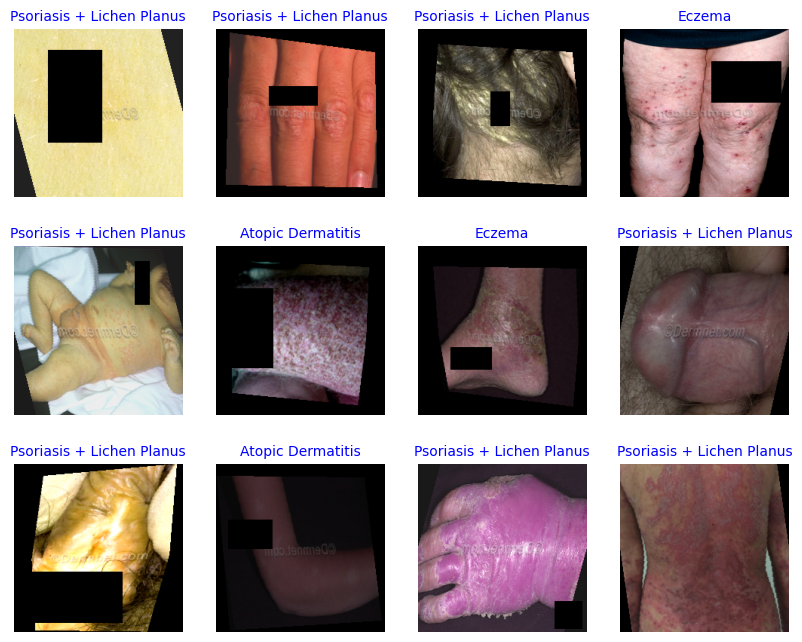

In [11]:
example_list = [train[i] for i in random.sample(range(len(train)), k=12)]

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for ax, img_item in zip(axes.ravel(), example_list):
    img = transforms.functional.to_pil_image(img_item['img'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(train.target_dict[img_item['target']], fontsize=10, color="blue")

plt.show()

In [13]:
# Set the device
c_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = c_device.type == 'cuda'
print(f"device: {c_device}")

batch_s = 64

# Create dataloaders for training and test sets
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_s, shuffle=True, pin_memory=pin_memory, num_workers=3)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_s, pin_memory=pin_memory, num_workers=3)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_s, pin_memory=pin_memory, num_workers=3)

batch = next(iter(train_loader))
print(batch['img'].shape)
print(batch['target'].shape)

device: cuda
torch.Size([64, 3, 224, 224])
torch.Size([64])


# Torch lightning

In [22]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from sklearn.metrics import classification_report
import seaborn as sns


NUM_CLASSES = 3
efficientnet_model = efficientnet_b0(weights="IMAGENET1K_V1")  # Load pre-trained weights
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(efficientnet_model.classifier[1].in_features, NUM_CLASSES)  # Adjust output layer
)

# from torchvision.models import resnet18, ResNet18_Weights

# resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) 
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASSES)



class MyLitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = efficientnet_model
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.loss_fn = nn.CrossEntropyLoss() 
        self.conf_matrix = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
        self.all_preds = []
        self.all_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc)

    def configure_optimizers(self):
       optimizer = optim.Adam(self.parameters(), lr=0.001) #, weight_decay=1e-4
       scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2, min_lr=1e-6, verbose=True)
       return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val_loss",
           },
       }

    def test_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        y_hat = self(x).argmax(dim=1)  # Predicted class
        self.conf_matrix.update(y_hat, y)  # Update confusion matrix
        self.all_preds.append(y_hat)  # Collect predictions
        self.all_labels.append(y)  # Collect true labels
        return {"preds": y_hat, "targets": y}

    def on_test_epoch_end(self):
        # print classification report 
        y_names = test.target_dict
        preds = torch.cat(self.all_preds, dim=0).cpu().numpy()
        labels = torch.cat(self.all_labels, dim=0).cpu().numpy()
        report = classification_report(labels, preds, target_names=[test.target_dict[0], test.target_dict[1], test.target_dict[2]])  # Adjust for your classes
        print(report)
        self.all_preds.clear()
        self.all_labels.clear()
        # Plot confusion matrix
        cm = self.conf_matrix.compute().cpu().numpy()
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger


model = MyLitModel()
logger = CSVLogger(save_dir="logs/", name="csv_logs")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    logger=logger, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)]
)

trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [24]:
 os.listdir("/kaggle/working/logs/csv_logs/") 

['version_1', 'version_0']

In [25]:
import pandas as pd
log_path = "logs/csv_logs/version_1/metrics.csv"
df = pd.read_csv(log_path, sep=',')
df = df.groupby('epoch').mean()  # merge the train and valid rows
df['epoch'] = df.index  # because "Epoch" gets turned into the index
df.index.name = ''  # to remove the name "Epoch" from the index
df

,step,train_accuracy,train_loss,val_accuracy,val_loss,epoch
,,,,,,
0,55.500000,0.625000,0.918762,0.593625,0.884026,0
1,112.000000,0.546875,0.966217,0.681275,0.756659,1
2,168.500000,0.640625,0.918916,0.707171,0.740941,2
3,233.000000,0.726562,0.722756,0.725100,0.693874,3
4,306.500000,0.750000,0.628035,0.721116,0.680377,4
5,363.000000,0.750000,0.538535,0.737052,0.655064,5
6,419.500000,0.734375,0.626651,0.752988,0.637863,6
7,483.666667,0.820312,0.462044,0.745020,0.725100,7
8,557.500000,0.781250,0.533880,0.770916,0.693698,8


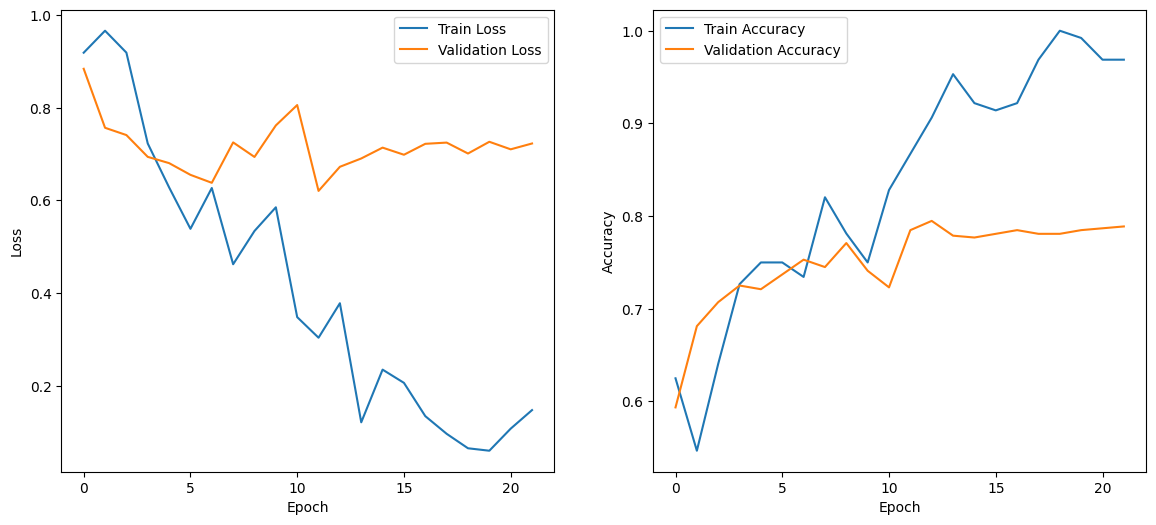

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(df["epoch"], df["train_loss"], label="Train Loss")
axes[0].plot(df["epoch"], df["val_loss"], label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(df["epoch"], df["train_accuracy"], label="Train Accuracy")
axes[1].plot(df["epoch"], df["val_accuracy"], label="Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()


plt.show()

{0: 'Psoriasis + Lichen Planus', 1: 'Eczema', 2: 'Atopic Dermatitis'}


Testing: |          | 0/? [00:00<?, ?it/s]

                           precision    recall  f1-score   support

Psoriasis + Lichen Planus       0.81      0.80      0.80       205
                   Eczema       0.78      0.76      0.77       167
        Atopic Dermatitis       0.71      0.75      0.73       125

                 accuracy                           0.77       497
                macro avg       0.77      0.77      0.77       497
             weighted avg       0.77      0.77      0.77       497



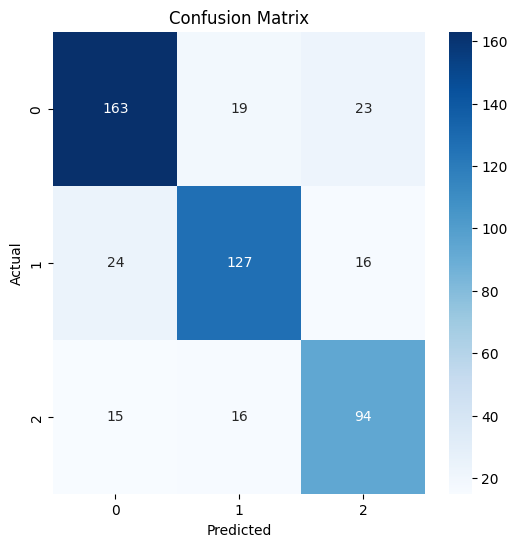

[{}]

In [27]:
print(test.target_dict)
trainer.test(model, dataloaders=test_loader)